Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# FineTuning NLP Models with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we demonstrate how to use the FLAML library to fine tune an NLP language model with hyperparameter search. 

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook,nlp]
```

In [1]:
!pip install flaml[nlp,ray,notebook];
# from v0.6.6, catboost is made an optional dependency to build conda package.
# to install catboost without installing the notebook option, you can run:
# !pip install flaml[catboost]

## 2. Sentiment Classification Example
## Load data and preprocess

The Stanford Sentiment treebank (SST-2) dataset is a dataset for sentiment classification. First, let's load this dataset into pandas dataframes:

In [2]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "sst2", split="train").to_pandas()
dev_dataset = load_dataset("glue", "sst2", split="validation").to_pandas()
test_dataset = load_dataset("glue", "sst2", split="test").to_pandas()

Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


Take a look at the first 5 examples of this dataset:

In [3]:
train_dataset.head(5)

,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4


Separate the data into X and y:

In [4]:
custom_sent_keys = ["sentence"]          # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

### Run FLAML

In [5]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [6]:
automl_settings = {
    "time_budget": 100,                                 # setting the time budget
    "task": "seq-classification",                       # specifying your task is seq-classification 
    "custom_hpo_args": {"output_dir": "data/output/"},  # specifying your output directory
    "gpu_per_trial": 1,  
    "log_file_name": "seqclass.log"                               # set to 0 if no GPU is available
}

In [7]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

/data/xliu127/projects/hyperopt/FLAML/flaml/data.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[str_columns] = X[str_columns].astype("string")
[flaml.automl: 02-26 15:22:48] {2059} INFO - task = seq-classification
[flaml.automl: 02-26 15:22:48] {2061} INFO - Data split method: stratified
[flaml.automl: 02-26 15:22:48] {2065} INFO - Evaluation method: holdout
[flaml.automl: 02-26 15:22:48] {2146} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 02-26 15:22:48] {2204} INFO - List of ML learners in AutoML Run: ['transformer']
[flaml.automl: 02-26 15:22:48] {2457} INFO - iteration 0, current learner transformer
/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This imp

{'eval_loss': 0.14093726873397827, 'eval_automl_metric': 0.04587155963302747, 'eval_runtime': 8.2421, 'eval_samples_per_second': 105.799, 'eval_steps_per_second': 105.799, 'epoch': 0.23}
{'eval_loss': 0.14093726873397827, 'eval_automl_metric': 0.04587155963302747, 'eval_runtime': 8.27, 'eval_samples_per_second': 105.441, 'eval_steps_per_second': 105.441, 'epoch': 0.23}
{'train_runtime': 38.3098, 'train_samples_per_second': 783.088, 'train_steps_per_second': 24.511, 'train_loss': 0.1946606031605895, 'epoch': 0.23}


***** Running Prediction *****
  Num examples = 872
  Batch size = 4
[flaml.automl: 02-26 15:24:03] {2572} INFO - Estimated sufficient time budget=5080918s. Estimated necessary time budget=5081s.
[flaml.automl: 02-26 15:24:03] {2619} INFO -  at 75.7s,	estimator transformer's best error=0.0459,	best estimator transformer's best error=0.0459
[flaml.automl: 02-26 15:24:03] {2739} INFO - selected model: RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(

### Best model and metric

In [8]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: transformer
Best hyperparmeter config: {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 3.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 71, 'FLAML_sample_size': 10000}
Best accuracy on validation data: 0.9541
Training duration of best run: 75.44 s


In [9]:
automl.model.estimator

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [10]:
'''pickle and save the automl object'''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open('automl.pkl', 'rb') as f:
    automl = pickle.load(f)

In [11]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 1821
  Batch size = 4


Predicted labels [0 0 1 ... 1 1 1]


### Log history

In [12]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=240)
for config in config_history:
    print(config)

{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 3.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 71, 'FLAML_sample_size': 10000}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 3.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 71, 'FLAML_sample_size': 10000}}


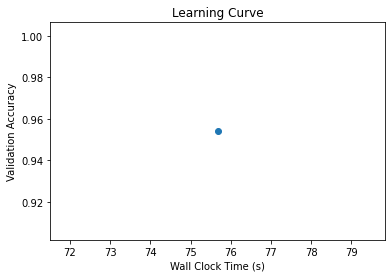

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Paraphrase Detection Example
### Load data and preprocess

The Microsoft Research Parallel Corpus (MRPC) is a dataset for paraphrase detection. An example pair of sentences is:

* sentence 1: Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .
* sentence 2: Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .

First, let's load this dataset in to pandas dataframes: 

In [14]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "mrpc", split="train").to_pandas()
dev_dataset = load_dataset("glue", "mrpc", split="validation").to_pandas()
test_dataset = load_dataset("glue", "mrpc", split="test").to_pandas()


Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


The first 5 examples of this dataset:

In [15]:
train_dataset.head(5)

,sentence1,sentence2,label,idx
0,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",1,0
1,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0,1
2,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",1,2
3,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0,3
4,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,1,4


### Run FLAML

In [16]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

[flaml.automl: 02-26 15:24:47] {620} WARNING - checkpoint data/output/train_2022-02-26_15-22-52/train_02792629_1_n=1e-06,s=9223372036854775807,e=1e-05,s=-1,s=3.0,e=32,d=42,o=0.0,y=0.0_2022-02-26_15-22-52/checkpoint-71 not found


In [30]:
automl_settings = {
    "time_budget": 100,                                 # setting the time budget
    "task": "seq-classification",                       # specifying your task is seq-classification 
    "custom_hpo_args": {"output_dir": "data/output/"},  # specifying your output directory
    "gpu_per_trial": 1,    
    "log_file_name": "seqclass.log"                             # set to 0 if no GPU is available
}

In [23]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

[flaml.automl: 02-26 15:27:21] {2059} INFO - task = seq-classification
[flaml.automl: 02-26 15:27:21] {2061} INFO - Data split method: stratified
[flaml.automl: 02-26 15:27:21] {2065} INFO - Evaluation method: holdout
[flaml.automl: 02-26 15:27:21] {2146} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 02-26 15:27:21] {2204} INFO - List of ML learners in AutoML Run: ['transformer']
[flaml.automl: 02-26 15:27:21] {2457} INFO - iteration 0, current learner transformer
/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.14149832725524902, 'eval_automl_metric': 0.044724770642201817, 'eval_runtime': 9.8455, 'eval_samples_per_second': 88.569, 'eval_steps_per_second': 88.569, 'epoch': 0.22}
{'eval_loss': 0.14149832725524902, 'eval_automl_metric': 0.044724770642201817, 'eval_runtime': 10.3417, 'eval_samples_per_second': 84.319, 'eval_steps_per_second': 84.319, 'epoch': 0.22}
{'train_runtime': 39.5017, 'train_samples_per_second': 759.46, 'train_steps_per_second': 23.771, 'train_loss': 0.19679561559704767, 'epoch': 0.22}


***** Running Prediction *****
  Num examples = 872
  Batch size = 4
[flaml.automl: 02-26 15:28:26] {2572} INFO - Estimated sufficient time budget=4394880s. Estimated necessary time budget=4395s.
[flaml.automl: 02-26 15:28:26] {2619} INFO -  at 65.4s,	estimator transformer's best error=0.0447,	best estimator transformer's best error=0.0447
[flaml.automl: 02-26 15:28:26] {2739} INFO - selected model: RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(

### Best model and metric

In [24]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: transformer
Best hyperparmeter config: {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 3.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 69, 'FLAML_sample_size': 10000}
Best accuracy on validation data: 0.9553
Training duration of best run: 65.26 s


In [25]:
automl.model.estimator

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [ ]:
'''pickle and save the automl object'''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open('automl.pkl', 'rb') as f:
    automl = pickle.load(f)

In [27]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 1821
  Batch size = 4


Predicted labels [0 0 1 ... 1 1 1]




### Log history

In [31]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=240)
for config in config_history:
    print(config)

{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 3.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 71, 'FLAML_sample_size': 10000}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 3.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 71, 'FLAML_sample_size': 10000}}


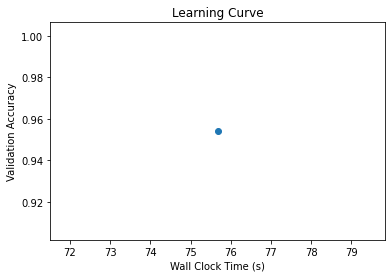

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()